In [ ]:
# ------------------------------------------------------------

In [ ]:
# Generate list of UKBiobank GWAS Morning/Evening person (1180) associations
# cut -f1-4,8,11,12 ukbiobank_gwas_round2_signif.tsv | { head -1; grep -w 1180$; } > nealelab_1180.bed &
# Takes ~30 minutes

In [1]:
MORNINGNESS_FILE = 'data/nealelab_1180.bed'
BROWNING_FILE = '/dors/capra_lab/data/ancient_dna/archaic_hominin/browning18/introgressed_variants/introgressed_variants_browning18_hg19.bed'


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
pd.set_option('display.max_rows', 600)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")


In [3]:
def column_name_mapping(df):
    mapping = {df.columns[0]: 'Chr', 
               df.columns[1]: 'Start', 
               df.columns[2]: 'End'}
    df = df.rename(columns=mapping)
    return df


In [23]:
# LOAD FILES

chronotype = pd.read_csv(MORNINGNESS_FILE, sep='\t')
chronotype = column_name_mapping(chronotype)

introgressed = pd.read_csv(BROWNING_FILE, sep='\t').iloc[:,[0,1,2,3]]
introgressed = column_name_mapping(introgressed)


In [6]:
# Merge dataframes and sort by pvalue
df_full = pd.merge(chronotype,introgressed,on=['Chr','Start','End'])
df_full.sort_values(by='pval',inplace=True,ascending=True)


In [7]:
# Check for duplicated variants
df_full[df_full['ID'].duplicated(keep=False)]


,Chr,Start,End,Ref/Alt,beta,pval,phenotype,ID
32310,chr13,73586259,73586260,C/T,0.006640,0.026187,1180,rs111537727
32309,chr13,73586259,73586260,C/A,-0.080405,0.033045,1180,rs111537727


In [8]:
# Drop second duplicated row
df_full = df_full.drop_duplicates(subset='ID', keep='first')
df_full = df_full.reset_index(drop=True)


In [21]:
df_full.head()

,Chr,Start,End,Ref/Alt,beta,pval,phenotype,ID
0,chr2,239311504,239311505,C/T,0.041197,7.275790e-24,1180,rs80271258
1,chr2,239311368,239311369,C/T,0.041180,7.455270e-24,1180,rs57435966
2,chr2,239302567,239302568,G/A,0.041098,8.758850e-24,1180,rs74979875
3,chr2,239307112,239307113,A/G,0.040902,1.347560e-23,1180,rs77008212
4,chr2,239282141,239282142,G/T,0.040952,1.357370e-23,1180,rs149249498


In [22]:
# Create cummulative morningness percentage using beta values
# Add log10 P-value column
c=0
l=[]
for i in range(len(df_full)):
    if df_full['beta'][i] >= 0:
        c+=1
    l.append([df_full['ID'][i],df_full['beta'][i],(df_full['pval'][i]),math.log10(df_full['pval'][i]),c/(i+1)])
    #l.append([math.log10(df_short['pval'][i]),c/(i+1)])
    
df_plot = pd.DataFrame(l,columns=['RSID','Beta','P-Value','log10 P-Value','% Morningness'])


In [23]:
df_plot[df_plot['RSID'].isin(['rs72984594'])]

,RSID,Beta,P-Value,log10 P-Value,% Morningness
189,rs72984594,0.023426,7.818520e-12,-11.106875,0.521053


In [24]:
# SAVE
#df_plot.to_csv('data/plotting_ukbb_morningness_introgressed_direction_of_effect.txt',
#               sep='\t', index=False)


In [25]:
# -----------------------------------------------------------------------
# PREPARE INPUT DATA FOR CLUMPING IN PLINK
# Create input file containing columns: SNP|PVAL
# Download MAGMA CEU: wget https://ctg.cncr.nl/software/MAGMA/ref_data/g1000_eur.zip
# plink --bfile g1000_eur --clump /dors/capra_lab/users/velazqks/projects/neanderthal_circadian/notebooks/data/input_clump_ukbb_gwas_1180.txt --clump-r2 0.90 --clump-field P --clump-p1 1
# cp plink.clumped /dors/capra_lab/users/velazqks/projects/neanderthal_circadian/notebooks/data/


In [26]:
to_clump_1180 = df_full[['ID','pval']].copy()
to_clump_1180.rename(columns={'ID':'SNP','pval':'P'},inplace=True)

In [27]:
to_clump_1180 = to_clump_1180[to_clump_1180['SNP'].str.startswith('rs')]

In [28]:
# SAVE
#to_clump_1180.to_csv('data/input_clump_ukbb_gwas_1180.txt',sep='\t', index=False)

In [29]:
# ---------------------------------------------------
# WRANGLE PLINK CLUMPED FILE

In [31]:
f = open('data/ukbb_morningness_introgressed_direction_of_effect.clumped').readlines()
fl = [line.split() for line in f]
df_clumped = pd.DataFrame(fl[1:], columns=fl[0:1][0])
#df_clumped.columns = fl[0:1][0]
df_clumped.dropna(inplace=True)

In [32]:
# FILTER COLUMNS
df_clumped = df_clumped[['CHR','BP','SNP','TOTAL','SP2']]

In [33]:
#ids = df_full['ID']
#ids.rename(columns={'ID':'SNP'},inplace=True)
df_clumped.rename(columns={'SNP':'ID'}, inplace=True)


In [34]:
# GET LOCI, BETA, AND PVAL COLUMNS
df_clump_merge = pd.merge(df_clumped,df_full,on='ID')

In [59]:
# GENERATE CUMULATIVE MORNINGNESS PERCENTAGE AND LOG10 PVALUE
c=0
l=[]
for i in range(len(df_clump_merge)):
    if df_clump_merge['beta'][i] >= 0:
        c+=1
    l.append([df_clump_merge['ID'][i],df_clump_merge['beta'][i],(df_clump_merge['pval'][i]),math.log10(df_clump_merge['pval'][i]),c/(i+1)])
    #l.append([math.log10(df_short['pval'][i]),c/(i+1)])
    
clump_plot = pd.DataFrame(l,columns=['RSID','Beta','P-Value','log10 P-Value','% Morningness'])

In [36]:
clump_plot.head()

,RSID,Beta,P-Value,log10 P-Value,% Morningness
0,rs80271258,0.041197,7.275790e-24,-23.138120,1.0
1,rs75804782,0.032813,5.890100e-21,-20.229877,1.0
2,rs55694368,0.034115,1.820190e-20,-19.739883,1.0
3,rs72983834,0.032439,2.420690e-20,-19.616061,1.0
4,rs112779025,0.044829,9.386490e-20,-19.027497,1.0


In [38]:
# SAVE
#clump_plot.to_csv('data/plotting_ukbb_morningness_introgressed_direction_of_effect_clump.txt',
#               sep='\t', index=False)

In [ ]:
# ----------------------------------------------------------------------


In [66]:
ci = pd.read_csv('../data/circadian_variants_introgressed.bed', sep='\t')['ID'].drop_duplicates()
clump_c = df_clump_merge[df_clump_merge['ID'].isin(ci)].reset_index(drop=True)

# GENERATE CUMULATIVE MORNINGNESS PERCENTAGE AND LOG10 PVALUE
c=0
l=[]
for i in range(len(clump_c)):
    if clump_c['beta'][i] >= 0:
        c+=1
    l.append([clump_c['ID'][i],clump_c['beta'][i],(clump_c['pval'][i]),math.log10(clump_c['pval'][i]),c/(i+1)])
    #l.append([math.log10(df_short['pval'][i]),c/(i+1)])
    
clump_c_plot = pd.DataFrame(l,columns=['RSID','Beta','P-Value','log10 P-Value','% Morningness'])


In [68]:
# SAVE
clump_c_plot.to_csv('data/plotting_ukbb_morningness_introgressed_c_direction_of_effect_clump.txt',
               sep='\t', index=False)

In [54]:
def add_loci_col(df):
    df['Loci'] = df.iloc[:,0]+'_'+df.iloc[:,2].astype(str)
    return df


In [55]:
chronotype = add_loci_col(chronotype)
introgressed = add_loci_col(introgressed)

In [60]:
non_introg=chronotype[~chronotype['Loci'].isin(introgressed['Loci'])]

In [64]:
non_introg.sort_values(by='pval',inplace=True)

/home/velazqks/.conda/envs/ksva/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
pd.set_option('display.max_rows', 600)
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("whitegrid")
sns.set_context("poster")


In [84]:
c=0
l=[]
for i in range(len(non_introg)):
    if non_introg['beta'][i] >= 0:
        #print(non_introg['beta'][i])
        c+=1
    l.append([non_introg['Loci'][i],non_introg['beta'][i],(non_introg['pval'][i]),math.log10(non_introg['pval'][i]),c/(i+1)])
    

In [85]:
no_i_plot = pd.DataFrame(l,columns=['Loci','Beta','P-Value','log10 P-Value','% Morningness'])

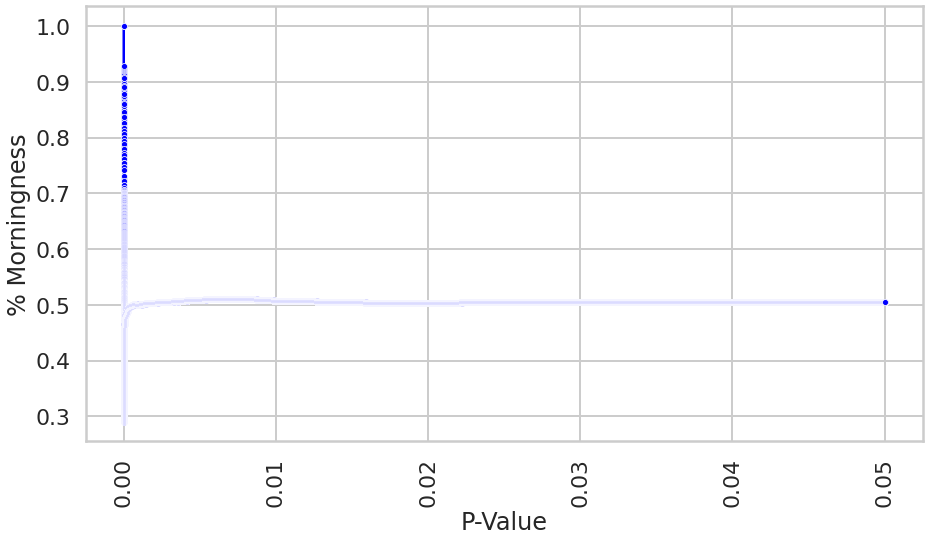

In [89]:
# 
sns.lineplot(x='P-Value',y='% Morningness',data=no_i_plot, 
             color='blue', linewidth=2.5, marker='o',markersize=6)
plt.xticks(rotation=90);
#plt.title('{} bins'.format(6))
#plt.savefig("plots/ukbb_morningness_introgressed_direction_of_effect_clump.pdf", dpi=300)
plt.show()

In [81]:
non_introg.reset_index(drop=True,inplace=True)

In [92]:
introgressed

,Chr,Start,End,ID,Loci
0,chr1,713157,713158,rs183634591,chr1_713158
1,chr1,713249,713250,rs149143617,chr1_713250
2,chr1,714621,714622,rs117741916,chr1_714622
3,chr1,715141,715142,rs151120166,chr1_715142
4,chr1,715516,715517,rs138194918,chr1_715517
...,...,...,...,...,...
900897,chr9,141092111,141092112,rs548368184,chr9_141092112
900898,chr9,141099782,141099783,rs148685139,chr9_141099783
900899,chr9,141102168,141102169,rs145761426,chr9_141102169
900900,chr9,141103292,141103293,rs566854511,chr9_141103293
